<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S41_logistics_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import plotly.express as px
import plotly.graph_objects as go
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook import logistics

# Continuous State

> Our warehouse robots live in the 2D plane, but have no notion of orientation.

In [3]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(4, 1, "steampunk", 1))

Imagine a vast warehouse, with rows of storage, a flat concrete floor, and many people operating alongside robots to fulfill orders and replenish inventory. 
In logistics applications of this kind, the main job of the robot is to transport items from one location
to another. An accurate and complete map of the warehouse layout is typically available, and the motion
of the robot is fairly simple, often restricted to translation in directions that are parallel to coordinate
axes defined by the arrangement of storage shelves. 
Such motions can be achieved by a robot equipped with omni-wheels, which allow instantaneous
motion in any direction.
Because the robot's motion is limited to pure translation, the orientation of the robot
does not change, and need not be considered when defining the robot state.
Furthermore, because these robots typically move at relatively low speeds, we need not consider forces
(or wheel torques) that are required to effect these motions.

For this special case of robots that translate in the plane, and whose instantaneous
velocity is the command input, the state space is merely the location of the robot
in the world with respect to some global coordinate frame:

$$x\in {\cal D} \subset \mathbb{R}^2$$

In the remainder of this chapter, we will consider a rectangular warehouse
that is 100 by 50 meters, a good size warehouse, similar to a typical DIY store.
In this case, $ {\cal D} = [0,100] \times [0,50]$.

In previous chapters, we considered discrete state spaces (categories of objects, rooms in a house). Here, the
state space is continuous, which brings a need for more sophisticated methods for dealing with uncertainty.
We can broadly divide these approaches into two categories: 
directly using exact, parameterized probability density functions (pdf's),
and using discrete approximations to probability distributions.
When using exact pdf's, we will restrict our attention to the multivariate (in our case, bivariate) Gaussian distribution
to characterize uncertainty in state.
We have previously used univariate Gaussians to model weight for our trash sorting robot,
and the extension to the 2D case is not so difficulty.
In the of approximate representations of probability distributions,
we will introduce two complementary methods: a finite element method, and a sampling-based method.
In the former, we approximate the state space by a two-diminsional grid, and keep track of the
probability mass in each individual grid cell. This is 
In the latter, we represent a pdf by a weighted collection of samples.
This representation is particularly amenable to propagating uncertainties that arise during
robot motion.

## Gaussian Densities

As we have seen with the trash sorting robot, a one-dimensional Gaussian density can be used
to represent continuous random variables.
The Gaussian probability density function (pdf) is defined by

$$\mathcal{N}(x;\mu,\sigma^2) \doteq \frac{1}{k} \exp\{ - \frac{1}{2} \frac{\|x-\mu\|^2}{\sigma^2} \}$$

where $\mu$ is the mean, $\sigma^2$ is the variance, and $k=\sqrt{2\pi}\sigma$ is a normalization constant.
It is instructive to consider the term in the exponent.
1. The term $\|x-\mu\|$ is the distance from $x$ to the mean.
2. The term $\|x-\mu\|^2$ is the squared distance from $x$ to the mean.
3. The term $\sigma^{-2}\|x-\mu\|^2$ is a weighted squared-distance to the mean.

Thus, we can interpret the negative log of a 1D Gaussian as a simple quadratic error or "energy" function. This fact is worth emphasizing: *a Gaussian density is the probability density associated with a quadratic error function with zero error at the mean $\mu$ and curvature $\sigma^2$.* We suggestively write this quadratic below as

$$\mathcal{E}(x;\mu,\sigma^2) \doteq \frac{1}{2} (x-\mu)\sigma^{-2}(x-\mu)$$

The energy analogy can be extended to the multivariate case.
In the 1D case, the mean and variance are scalars.
For the $n$-dimensional case when $x\in\mathbb{R}^n$, the mean is a vector,  $\mu\in\mathbb{R}^n$,
and the concept of variance is extended to define a 
**covariance matrix** $\Sigma\in\mathbb{R}^{n\times n}$,
a symmetric, positive definite matrix that characterizes the curvature of a quadratic in multiple dimensions. 
This allows us to generalize the 1D error function above to the $n$-dimensional case as

$$\mathcal{E}(x;\mu,\Sigma) \doteq \frac{1}{2} (x-\mu)^T\Sigma^{-1}(x-\mu)$$

We define a **multivariate Gaussian density** using the error function $\mathcal{E}(x;\mu,\Sigma)$
as follows

$$\mathcal{N}(x;\mu,\Sigma) \doteq \frac{1}{k} \exp\{ - \frac{1}{2} (x-\mu)^T\Sigma^{-1}(x-\mu) \}$$

The (non-obvious) normalization constant k can be written very elegantly by taking the determinant of $2\pi\Sigma$:

$$k=\sqrt{(2\pi)^{n}|\Sigma|}=\sqrt{|2\pi\Sigma|}.$$

Another name for multivariate Gaussian probability density is the multivariate normal distribution. We prefer to use *density* to denote its continuous nature, and Gaussian instead of "normal", but It is good to be aware of both nomenclatures.

To better understand the multivariate Gaussian pdf, consider a simple two-dimensional example,

$$
\begin{aligned}
\mu &= \begin{bmatrix} 4 \\ 10 \end{bmatrix} \\
\\
\Sigma &= \begin{bmatrix} 
\sigma^2_{xx} & 0 \\
0 & \sigma^2_{yy} 
\end{bmatrix}
\end{aligned}
$$

If we evaluate $\mathcal{E}(x;\mu,\Sigma)$ for this case, we obtain

$$\mathcal{E}(x;\mu,\Sigma) = \frac{1}{\sigma^2_{xx}}(x - 4)^2 + \frac{1}{\sigma^2_{yy}}(y - 10)^2
$$

which is the familiar equation of an axis-aligned ellipse in the plane with center at $(4, 10)$.
This form gives a nice geometric interpretation to the Gaussian pdf.
For any constant $k$,
the value of  $\mathcal{N}(x;\mu,\Sigma)$ is constant for all $x$ that satisfy 
$\mathcal{E}(x;\mu,\Sigma) = k$.
For a 2D Gaussian, the level sets $\{ x \; | \; \mathcal{E}(x;\mu,\Sigma) = k \}$ always take the form
of a concentric ellipses (centered at $\mu$) whose axes are determined by the covariance matrix $\Sigma$.
When illustrating 2D Gaussian pdf's, it is typical to show a few level sets (as in the example below),
which is why there are so many ellipses in the figures below.

 In python, none of the packages we rely on in gtbook define a Gaussian, but it is easy enough to do in code:

In [4]:
def gaussian(x:np.array, mean=np.zeros((2,)), cov=np.eye(2)):
    """Evaluate multivariate Gaussian at x of shape(m,n), yields (m,) vector."""
    assert x.shape[-1]==2, f"error: x has shape {x.shape}"
    k = math.sqrt(np.linalg.det(2*math.pi*cov))
    e = x - mean
    E = np.sum(0.5 * (e @ np.linalg.inv(cov) * e), axis=-1)
    return np.exp(-E)/k

The simple code above has limitations: it *only* works for dimensionality $n\geq2$. It could be made to work for 1D with some more work. In this chapter we will working in 2D, so below we show the effect of mean and covariance as density contour plots:

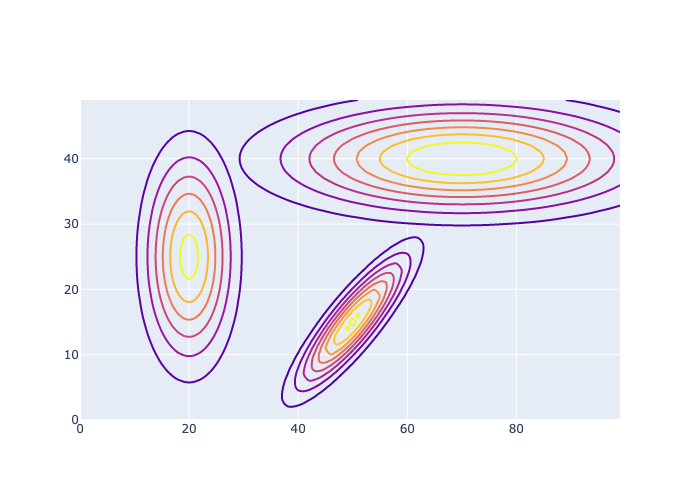

In [5]:
# show off some 2D Gaussians
means = [gtsam.Point2(x,y) for x,y in [(20,25),(70,40),(50,15)]]
covariances = [np.diag([sx**2,sy**2]) for sx,sy in [(5,10),(20,5)]]
covariances.append(np.array([[40,35],[35,40]]))

data = [go.Contour(z=gaussian(logistics.map_coords, mean, cov), contours_coloring='lines', 
        line_width=2, showscale=False) for mean,cov in zip(means,covariances)]
fig = go.Figure(data=data); fig.show()

The first two Gaussians above are *axis-parallel*, and the covariance matrices simply contain the squared standard deviations of the $x$ and $y$ dimensions on their diagonals. The third Gaussian shows off the case where $x$ and $y$ are positively correlated, around a mean of $(50,15)$.

The advantage of the Gaussian as a probability density is that it is easy to specify and easy to compute with. The disadvantage is that it is a very restricted class of densities: in particular, it is a *unimodal* density, meaning that it only has a single maximum. Hence, we will never be able to represent two equally probable locations in space, for example. One way to get around that is to use a *mixture* of Gaussian densities. This is a well known technique and has its merits, but is outside the scope of this book.

## The Finite Element Method

Representing uncertainty using multivariate Gaussians has the appeal of providing
an exact representation that depends on only a small number of parameters (the mean and covariance matrix).
However, as mentioned above, multivariate Gaussians suffer from several limitations,
including the inability to easily deal with multimodal distributions (e.g.,
if the robot thinks it could be in any one of several aisles,
but is fairly sure that it is located halfway down the aisle).
A second limitation of Gaussians is that they are... Gaussians, and therefore they
are of limited utility when uncertainty does not conform to the normal distribution.

One way to deal with these limitations is to introduce approximate, grid-based representations
of uncertainty.
With this approach, each grid cell contains an associated probability mass.
As the robot moves in the environment, the probabilities assigned to each grid cell
are updated based on noise in the motion model (as we'll see in the next section).
When sensor data is available, perception algorithms can be used to reduce uncertainty,
thereby concentrating probability mass in grid cells associated with higher likelihood
values (as we'll see in the section on perception).
Because this approximation does not rely on a parameterization of the pdf (e.g., it is
not specified by a mean and covariance matrix), it can be used to approximate any pdf,
with accuracy that depends on the number of cells in the grid.

Grid-based representations embody the classical trade-off between accuracy and complexity.
The accuracy of the representation depends on the resolution along the grid coordinate
axes, but the number of cells in the grid grows exponentially (with the dimension of the space)
as a function of this resolution.
Choosing the *resolution* for our discretization scheme is therefore a key design decision.
For example, if we pick 1x1 meter cells, we are looking at $100\times50=5000$ cells. But $1m^2$ seems a bit coarse for navigating with a robot. Could we get away with $10cm$ resolution? 
Here we immediately see difficulty that arises due to the exponential complexity associated to grids. In our case, increasing the resolution by 10, from 1 meter to 10cm, increases the number of cells needed by $10^2=100$, from 5000 to $1000\times500=500k$.
This difficulty, while significant in the 2D case, rapidly becomes untenable as the dimensionality of the problem
increases.

Below we show what the 1x1 meter discretization looks like for our warehouse example, using the same three Gaussian densities to illustrate a multimodal density:

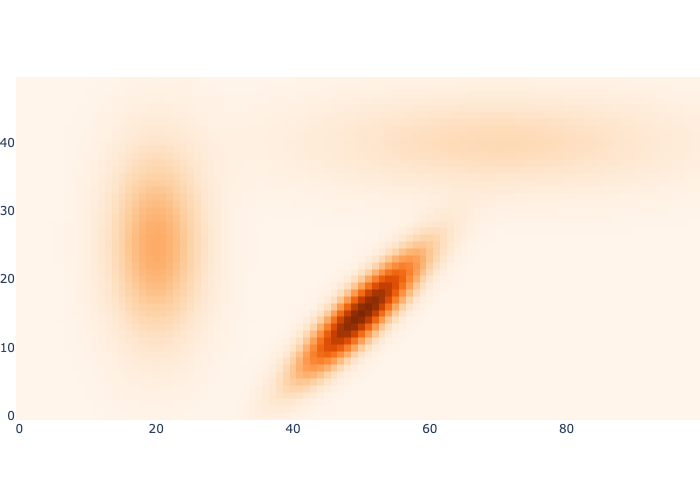

In [6]:
probabilities = np.zeros((50,100))
for mean,cov in zip(means,covariances):
    probabilities += gaussian(logistics.map_coords, mean, cov)
logistics.show_map(probabilities/np.max(probabilities))

## A Sampling-based representation.

Sampling-based methods offer a simple, efficient alternative. 
Grid-based representations can be remarkably inefficient:
regardless of how the probability mass is distributed over the state space, the number of cells
remains fixed, and each cell must be considered when propagating uncertainty.
Instead of discretizing the space and keeping track of the probability mass assigned to each grid cell,
we can discretize the probability mass, and keep track of how that probability mass moves through
the state space as uncertainty is propagated forward in time.
Sampling-based approaches do exactly this.

In sampling-based methods the density $p(x)$ is represented by a set of N random *samples* or,
often called *particles,* $S=\{s^{(i)};i\in1..N\}$ drawn from $p(x)$. 
We are able to do this because of the essential duality between the samples and the density from which they are generated: from the samples we can always approximately reconstruct the density, e.g. using a histogram.

Sampling-based approaches can be significantly more efficient than grid-based approaches.
First, the number of samples need not grow exponentially with the dimension of the space.
Second, because we (attempt to) keep only samples that represent significant concentrations of probability
mass, the number of samples will be small in areas that are unlikely.
Finally, sampling-based approaches lend themselves to computationally efficient simulation schemes,
and these can form the basis for perception algorithms used in localization (as we shall see shortly).

Below, we use a numpy random number generator (`rng`, defined in preamble) to sample from the three Gaussians we defined above, and display the resulting sets of samples as a scatter plot:

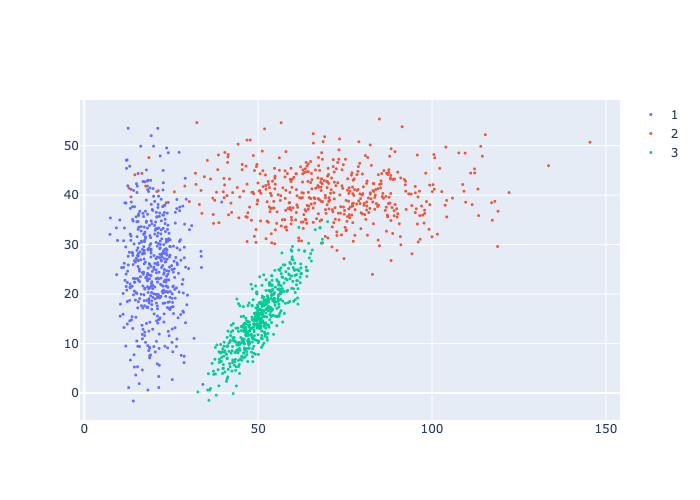

In [7]:
N=500
samples = [rng.multivariate_normal(mean, cov, size=N)
           for mean,cov in zip(means,covariances)]
data = [go.Scatter(x=sample[:,0],y=sample[:,1], mode="markers", 
        marker=dict(size=3), name=i+1) for i, sample in enumerate(samples)]
fig = go.Figure(data=data); fig.show()

## Computing Probabilities

In general, for continuous random variables, probability mass is computed by integrating probability density
over a domain.
In the 2D case,  we can find the probability of the state $x$ being contained in any finite region $S$ by integrating the pdf over $SS:

$$P(x\in S) = \int_{x\in S} p(x) dx$$

In the case of Gaussian pdfs, it is not possible to compute this integral in closed form, but
thanks to the nice geometric properties of the level sets of Gaussian pdfs, there
are efficient numerical methods to do so.

In the case of grid-based approximations, computing the probability mass assigned to a specific
region amounts to summing the probabilities associated to the grid cells that define that region.

For sampling-based approximations, a set of weighted samples can be used to construct
histogram-style representation of the probability distribution.

## GTSAM 101

> The GTSAM concepts used in this section, explained.

We really used only one concept from GTSAM above, which is `gtsam.Point2`. For maximal compatibility with numpy, in python this is just a function that creates a 2D, float numpy array. Inside GTSAM, it is represented as an Eigen vector, where Eigen is the C++ equivalent of numpy.

## GTbook 101

> About the support code we used above

Because in this chapter we will use the same code over and over again, we defined some of the key functions in the `gtbook` library accompanying this book. In particular, above we used the following variable:
- `logistics.map_coords`: a numpy array of shape (50, 100, 2) with x and y coordinates for every cell in the map, at 1m resolution.
- `logistics.show_map`: takes a probability image and plots it using plotly's `imshow` function

As always, you can get help on functions by calling `help`:

In [8]:
help(logistics.show_map)

Help on function show_map in module gtbook.logistics:

show_map(image=None, markers=None, file: str = None, marker={})
    Show image on warehouse map, possibly with markers

